### Pattern Recognition
### Assignment 4  
### COE19B007 - Praveen B R
#### Question 2

In [18]:
import cvxopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cvxopt.solvers.options['show_progress']=False

In [2]:
class Perceptron:
    def __init__(self,learning_rate=0.01,epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs
    
    def __activation_func(self,x):
        return 1 if x>=0 else 0
    
    def __predict(self,x):
        g=(self.weights.T).dot(x)
        return self.__activation_func(g)
    
    def __plot(self,X,y):
        color_cond = ['red' if i==1 else 'yellow' for i in y]
        plt.scatter(np.array(X[:, 1]), np.array(X[:, 2]), color=color_cond)
        slope = -(self.weights[1] / self.weights[2])
        intercept = -(self.weights[0] / self.weights[2])
        ax = plt.gca()
        x_vals = np.array(ax.get_xlim())
        y_vals = intercept + (slope * x_vals)
        plt.plot(x_vals, y_vals)
        plt.title('DECISION BOUNDARY')
        plt.show()
    
    def fit(self, X, y):
        self.X = np.hstack((np.ones((len(X), 1)), X))
        self.y = y
        self.weights = np.zeros(len(self.X[0]))
        self.epoch = 0
        while self.epoch < self.epochs:
            self.epoch = self.epoch + 1
            self.old_W = np.copy(self.weights)
            for index, x in enumerate(self.X):
                self.weights = self.weights + self.learning_rate * (self.y[index] - self.__predict(x)) * x
            if np.array_equal(self.weights, self.old_W):
                break
            print(f'Epoch {self.epoch} --> W: {self.weights}')
            self.__plot(self.X, self.y)
            
    def predict(self, X):
        if hasattr(self, 'weights'):
            X = np.hstack((np.ones((len(X), 1)), X))
            g = X @ self.weights
            return np.where(g >= 0, 1, 0)
        else:
            print('Please run fit in order to be able to use predict')
            
    @staticmethod
    def accuracy(y_true,y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

### perceptron

In [19]:
df = pd.DataFrame([[2, 2, 1], [-1, -3, 0], [-1, 2, 1], [0, -1, 0], [1, 3, 1], [-1, -2, 0], [1, -2, 0],[-1, -1, 1]])
df.columns = ['x1','x2','ω']
X = np.array(df.loc[:,['x1','x2']])
y = np.array(df.loc[:,'ω'])
df

,x1,x2,ω
0,2,2,1
1,-1,-3,0
2,-1,2,1
3,0,-1,0
4,1,3,1
5,-1,-2,0
6,1,-2,0
7,-1,-1,1


#### Perceptron with learning rate = 0.01

Epoch 1 --> W: [0.   0.   0.02]


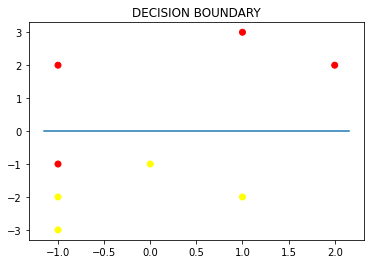

Epoch 2 --> W: [ 0.01 -0.01  0.01]


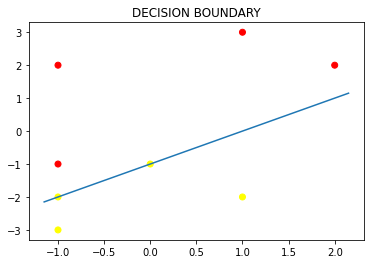

Epoch 3 --> W: [ 0.01 -0.02  0.01]


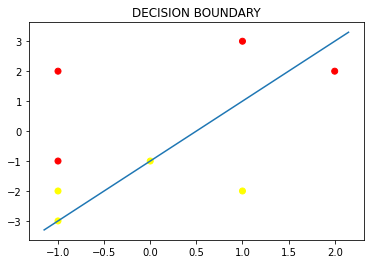

Epoch 4 --> W: [ 0.03 -0.01  0.02]


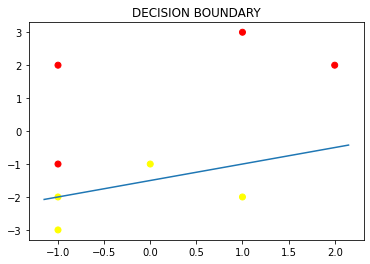

Epoch 5 --> W: [ 0.02 -0.01  0.03]


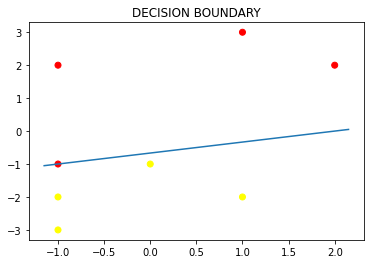

In [20]:
pcn=Perceptron(learning_rate=0.01, epochs=20)
pcn.fit(X, y)

In [21]:
y_pred = pcn.predict(X)
print(f"Accuracy: {pcn.accuracy(y, y_pred)}")

Accuracy: 1.0


#### Perceptron with learning rate = 0.5 

Epoch 1 --> W: [0. 0. 1.]


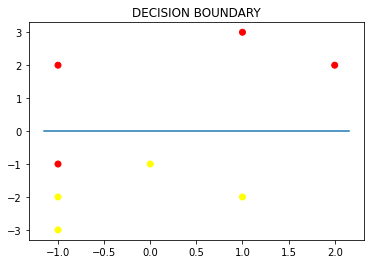

Epoch 2 --> W: [ 0.5 -0.5  0.5]


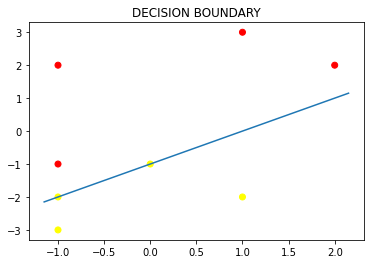

Epoch 3 --> W: [ 0.5 -1.   0.5]


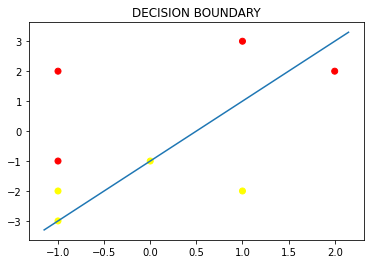

Epoch 4 --> W: [ 1.5 -0.5  1. ]


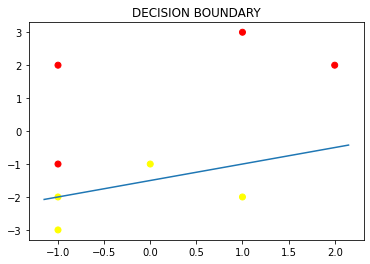

Epoch 5 --> W: [ 1.  -0.5  1.5]


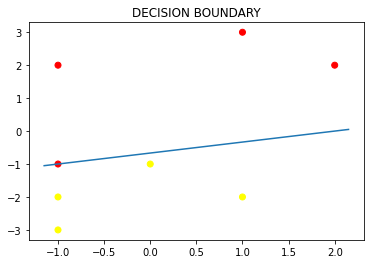

In [22]:
#training single perceptron with learning rate 0.01
pcn = Perceptron(learning_rate=0.5)
pcn.fit(X, y)

In [23]:
y_pred = pcn.predict(X)
print(f"Accuracy: {pcn.accuracy(y, y_pred)}")

Accuracy: 1.0


### SVM

In [24]:
def linear_kernel(x1, x2):
    return np.dot(x1,x2)
def poly_kernal(x,y,p=2):
    return(1+np.dot(x,y))**p
def gaussian_kernal(x,y,sigma=5.0):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * (sigma ** 2)))

In [25]:
class SVM:
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None:
            self.C = float(self.C)
   
    def fit(self,X,y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        y = y.astype(np.double)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
        
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)  
        a = np.ravel(solution['x'])
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print(f"{len(self.a)} support vectors out of {n_samples} points")
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        
        self.b /= len(self.a)
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w=None
        
                
    def project(self,X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b
    
    def predict(self,X):
        return np.sign(self.project(X))
    
    def get_nonlinear_equation(self):
        eq = np.zeros(6)
        for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
            eq += a * sv_y * np.asarray([sv[0] ** 2, sv[1] ** 2, 1, sv[0] * 2,sv[1] * 2, 2 * sv[0] * sv[1]])
        return eq
    
    def __str__(self):
        print("Classifier Details")
        print(f"Alpha: {self.a}")
        print(f"Bias: {self.b}")
        if self.kernel == linear_kernel:
            print(f"Weights: {self.w}")
            print(f"Center Margin Equation: {self.w[0]} x1 + {self.w[1]} x2 +{self.b} = 0")
        else:
            print("Weights: None")
            w = self.get_nonlinear_equation()
            print(f"Center Margin Equation: {w[0]} x1^2 + {w[1]} x2^2 + {w[3]}x1 + {w[4]} x2 + {w[5]} x1x2 + {w[2]} + {self.b} = 0")
        print(f"Support vectors: {self.sv}")
        return ""
   
    @staticmethod
    def accuracy(y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)
    
    def plot_decision_boundary(self, X, y):
        color = ['red' if c > 0 else 'blue' for c in y]
        plt.scatter(self.sv[:, 0], self.sv[:, 1], s=100, c="g")
        plt.scatter(X[:, 0], X[:, 1], c=color)
        w = self.w
        b = self.b
        a = -w[0] / w[1]
        xx = np.linspace(-1, 2)
        yy = a * xx - b / w[1]
        plt.plot(xx, yy, "k")
        yy = a * xx - (b + 1) / w[1]
        plt.plot(xx, yy, "k--")
        yy = a * xx - (b - 1) / w[1]
        plt.plot(xx, yy, "k--")
        plt.show()
    
    def plot_contour(self, X, y):
        X1_train = X[y == -1]
        X2_train = X[y != -1]
        color = ['red' if c > 0 else 'blue' for c in y]
        plt.scatter(self.sv[:, 0], self.sv[:, 1], s=100, c="g")
        plt.scatter(X[:, 0], X[:, 1], c=color)
        X1, X2 = np.meshgrid(np.linspace(0, 7, 20), np.linspace(-5, 10, 20))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = self.project(X).reshape(X1.shape)
        plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1,origin='lower')
        plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1,origin='lower')
        plt.show()


In [ ]:
df = pd.DataFrame([[2, 2, 1], [-1, -3, 0], [-1, 2, 1], [0, -1, 0], [1, 3, 1], [-1, -2, 0], [1, -2, 0],[-1, -1, 1]])
df.columns = ['x1','x2','ω']
X = np.array(df.loc[:,['x1','x2']])
y = np.array(df.loc[:,'ω'])
df

,x1,x2,ω
0,2,2,1
1,-1,-3,0
2,-1,2,1
3,0,-1,0
4,1,3,1
5,-1,-2,0
6,1,-2,0
7,-1,-1,1


4 support vectors out of 8 points

Accuracy: 1.0

Classifier Details
Alpha: [0.44320743 3.32962186 0.67037655 3.55679164]
Bias: 0.999999084367766
Weights: [-2.00000024  1.99999817]
Center Margin Equation: -2.000000240327787 x1 + 1.999998168735532 x2 +0.999999084367766 = 0
Support vectors: [[ 2  2]
 [ 0 -1]
 [-1 -2]
 [-1 -1]]



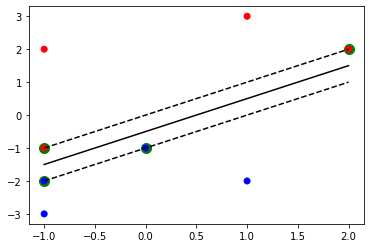

In [26]:
y = np.where(y <= 0, -1, 1)
svm = SVM()
svm.fit(X, y)
y_pred = svm.predict(X)
print(f"\nAccuracy: {svm.accuracy(y, y_pred)}\n")
print(svm)
svm.plot_decision_boundary(X, y)